In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

In [116]:
from proj.data.load import load_ibkr_prices, load_macro_series
from proj.utils.dates import duration_to_dates
from proj.features import transforms
from proj.evaluation.backtesting import rolling_forecast_backtest, evaluate_performance, ts_hyperparam_search, ts_cv_score
from proj.features.feature_selection import greedy_feature_selection

from proj.models.garch import GARCHRegressor
from proj.models.arima import ARIMA_RV_Model
from proj.models.xgb import XGBRVModel

In [51]:
plt.style.use("styler.mplstyle") 

In [52]:
DURATION = "5 Y"        # hyperparameter
END_DATE = None 

START_DATE, END_DATE = duration_to_dates(DURATION, end=END_DATE)
START_DATE, END_DATE

(datetime.date(2020, 11, 18), datetime.date(2025, 11, 18))

## Pre Processing

In [53]:

# Monthly
# macro = [
#     'CPIAUCSL',   # CPI (All Urban Consumers)
#     'INDPRO',     # Industrial Production Index
#     'CNP16OV',    # Civilian Noninstitutional Population, 16+
#     'FEDFUNDS',   # Effective Federal Funds Rate
#     'UNRATE'      # Unemployment Rate
# ]

# Daily
macro = [
    'VIXCLS',        # Implied equity vol
    'EFFR',          # Fed Fund rate (daily)
    'DGS2',          # 2-year Treasury yield
    'DGS10',         # 10-year Treasury yield
    'TEDRATE',       # Funding stress
    'DCOILWTICO',    # Crude oil spot
    'DHHNGSP',       # Natural gas
    'DEXUSEU',       # USD/EUR
]

In [54]:

macro_series = load_macro_series(macro, START_DATE, END_DATE)

In [55]:
macro_series

,DATE,VIXCLS,EFFR,DGS2,DGS10,TEDRATE,DCOILWTICO,DHHNGSP,DEXUSEU
0,2020-11-18,23.84,0.09,0.16,0.88,0.13,41.64,2.37,1.1869
1,2020-11-19,23.11,0.08,0.18,0.86,0.14,41.57,2.19,1.1843
2,2020-11-20,23.70,0.08,0.16,0.83,0.13,41.99,2.22,1.1857
3,2020-11-23,22.66,0.08,0.16,0.86,0.13,42.91,2.23,1.1826
4,2020-11-24,21.64,0.08,0.16,0.88,0.14,44.71,2.47,1.1874
...,...,...,...,...,...,...,...,...,...
1299,2025-11-11,17.28,3.87,3.58,4.13,0.09,60.94,3.80,1.1545
1300,2025-11-12,17.51,3.87,3.56,4.08,0.09,60.94,3.80,1.1592
1301,2025-11-13,20.00,3.88,3.58,4.11,0.09,60.94,3.80,1.1649
1302,2025-11-14,19.83,3.88,3.62,4.14,0.09,60.94,3.80,1.1617


In [56]:
stock_data = [
    'XLE',
    'SPY',
    # Crude Oil 
    ]

In [57]:
stock_series = await load_ibkr_prices(stock_data, DURATION)

Connected to Interactive Brokers successfully.


In [58]:
stock_series

,date,SPY,XLE
0,2020-11-20,355.33,35.81
1,2020-11-23,357.46,38.34
2,2020-11-24,363.22,40.31
3,2020-11-25,362.66,39.37
4,2020-11-27,363.67,38.91
...,...,...,...
1249,2025-11-12,683.38,90.25
1250,2025-11-13,672.04,90.48
1251,2025-11-14,671.93,92.02
1252,2025-11-17,665.67,90.34


In [59]:
stock_series['XLE_r'] = transforms.log_returns(stock_series, 'XLE')
stock_series['SPY_r'] = transforms.log_returns(stock_series, 'SPY')

In [60]:
df = stock_series.merge(macro_series, left_on='date', right_on=['DATE']).drop(columns=['date'])

In [61]:
df.dropna(inplace=True)

#### Stock and Indicators

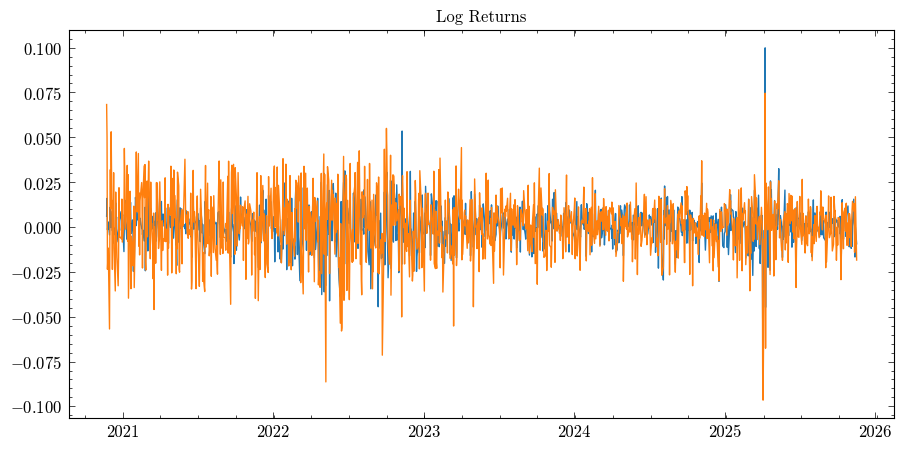

In [62]:
plt.figure(figsize=(10,5))
plt.title('Log Returns')
plt.plot(df['DATE'], df['SPY_r'])
plt.plot(df['DATE'], df['XLE_r'])

idiosyncratic volatility of XLE

In [63]:
X = df[['SPY_r']]   #
y = df['XLE_r']     

model = LinearRegression()
model.fit(X, y)


df['XLE_idio'] = y - model.predict(X)

In [84]:
df['XLE_idio_vol'] = transforms.realized_vol(df['XLE_idio'], window=21)

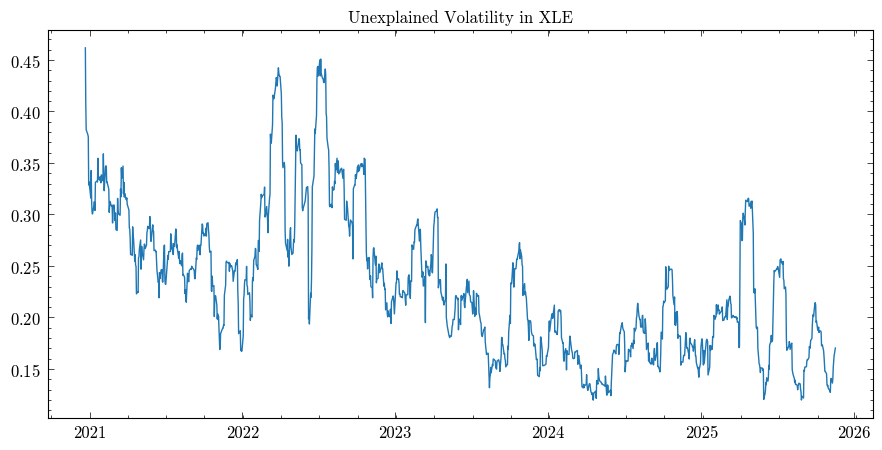

In [85]:
plt.figure(figsize=(10,5))
plt.title('Unexplained Volatility in XLE')
plt.plot(df['DATE'], df['XLE_idio_vol'] )

In [86]:
adfuller(df['XLE_idio_vol'].dropna())

(np.float64(-2.6205236998207644),
 np.float64(0.08882919053225907),
 21,
 1210,
 {'1%': np.float64(-3.4357658900670085),
  '5%': np.float64(-2.8639315921664568),
  '10%': np.float64(-2.5680433235434736)},
 np.float64(-7315.908205482552))

In [87]:
het_arch(df['XLE_idio'])

(np.float64(75.82136608394562),
 np.float64(3.2918635754881696e-12),
 8.00358529429683,
 1.3579357935845794e-12)

## Training

drop rows lost from rolling window

In [88]:
analysis = df.copy().dropna(subset=['XLE_idio_vol'])

In [89]:
train_size = .8
n = len(analysis)
n_rows = int(train_size * n)
TRAIN = analysis.iloc[: n_rows]

In [90]:
train_X = transforms.enforce_stationarity(TRAIN[macro]) # enforce stationary exogenous features
train_y = TRAIN['XLE_idio']    # garch input
train_y_vol = TRAIN['XLE_idio_vol'] # true target


### Feature Selection

In [91]:
selected_features, history_df = greedy_feature_selection(
    model=GARCHRegressor,
    model_params={'returns': train_y, 'p': 1, 'q': 1},
    X=train_X,
    y=train_y_vol, 
)

Initial qlike (no features): 2.9076417895088813
Step 1: added DCOILWTICO_d1, qlike = 2.3416012656679146
Step 2: added DHHNGSP_d1, qlike = 2.306504080829108
Step 3: added VIXCLS_d0, qlike = 2.2866871314765986


### Hyper Parameter Tuning

In [92]:
selected_exog = ['DCOILWTICO', 'DGS10', 'DHHNGSP']

In [93]:
train_X = transforms.enforce_stationarity(TRAIN[selected_exog]).to_numpy() # enforce stationary exogenous features
train_y = TRAIN['XLE_idio']    # garch input
train_y_vol = TRAIN['XLE_idio_vol'] # true target


### GARCH

In [149]:
param_grid = {
    "vol": ['ARCH', 'GARCH',  'EGARCH', 'FIGARCH', 'HARCH'],
    "p": [1, 2, 3],
    "q": [1, 2, 3],
    "mean_lags": [0, 1, 2],
    "dist": ['normal', 't', 'skewt']
}

best_params_garch, best_score_garch, all_scores_garch = ts_hyperparam_search(
    model_cls=GARCHRegressor,
    y=train_y_vol,  
    X=train_X,
    param_grid=param_grid,
    train_size=0.8,
    horizon=1,      
    verbose=True,
    model_init_kwargs={"returns": train_y},
)


Initial params: {'vol': 'ARCH', 'p': 1, 'q': 1, 'mean_lags': 0, 'dist': 'normal'} score: 3.4791279478949733

Optimizing parameter: vol
  tried vol=GARCH, score=2.405010
  tried vol=EGARCH, score=2.464700
  tried vol=FIGARCH, score=2.420446
  tried vol=HARCH, score=3.479119
Best vol after sweep: GARCH, score=2.405010

Optimizing parameter: p
  tried p=2, score=2.405021
  tried p=3, score=2.431442
Best p after sweep: 1, score=2.405010

Optimizing parameter: q
  tried q=2, score=2.395557
  tried q=3, score=2.387494
Best q after sweep: 3, score=2.387494

Optimizing parameter: mean_lags
  tried mean_lags=1, score=2.381878
  tried mean_lags=2, score=2.365811
Best mean_lags after sweep: 2, score=2.365811

Optimizing parameter: dist
  tried dist=t, score=2.314008
  tried dist=skewt, score=2.317737
Best dist after sweep: t, score=2.314008

Final best params: {'vol': 'GARCH', 'p': 1, 'q': 3, 'mean_lags': 2, 'dist': 't'}
Final best CV score: 2.314008145344929


best parameters

In [95]:
print(f"Best Parameters for GARCH: {best_params_garch}")
print(f"Best Score for GARCH: {best_score_garch}")

Best Parameters for GARCH: {'p': 1, 'q': 3, 'mean_lags': 2, 'dist': 't'}
Best Score for GARCH: 2.314008145344929


### ARIMA

In [ ]:
param_grid = {
    "p": [0, 1, 2],
    "d": [0],
    "q": [0, 1, 2],
    "seasonal_P": [0, 1],
    "seasonal_D": [0, 1],
    "seasonal_Q": [0, 1],
    "seasonal_s": [12],   
}

best_params_arima, best_score_arima, all_scores_arima = ts_hyperparam_search(
    model_cls=ARIMA_RV_Model,
    y=train_y_vol,   # full series for CV
    X=train_X,
    param_grid=param_grid,
    train_size=0.8,
    horizon=1,      
    verbose=True,
)


/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

Initial params: {'p': 0, 'd': 0, 'q': 0, 'seasonal_P': 0, 'seasonal_D': 0, 'seasonal_Q': 0, 'seasonal_s': 12} score: 0.38962163580289627

Optimizing parameter: p


/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

  tried p=1, score=0.070831
Best p after sweep: 1, score=0.070831

Optimizing parameter: d


/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

  tried d=1, score=0.079745
Best d after sweep: 0, score=0.070831

Optimizing parameter: q


/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

  tried q=1, score=0.071364
Best q after sweep: 0, score=0.070831

Optimizing parameter: seasonal_P


/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

  tried seasonal_P=1, score=0.070956
Best seasonal_P after sweep: 0, score=0.070831

Optimizing parameter: seasonal_D


/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

  tried seasonal_D=1, score=0.186239
Best seasonal_D after sweep: 0, score=0.070831

Optimizing parameter: seasonal_Q


/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

  tried seasonal_Q=1, score=0.071008
Best seasonal_Q after sweep: 0, score=0.070831

Optimizing parameter: seasonal_s
Best seasonal_s after sweep: 12, score=0.070831

Final best params: {'p': 1, 'd': 0, 'q': 0, 'seasonal_P': 0, 'seasonal_D': 0, 'seasonal_Q': 0, 'seasonal_s': 12}
Final best CV score: 0.07083068664428517


/home/jackyeung99/classes/proj_energy_volatility/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [80]:
print(f"Best Parameters for arima: {best_params_arima}")
print(f"Best Score for arima: {best_score_arima}")

Best Parameters for arima: {'p': 1, 'd': 0, 'q': 0, 'seasonal_P': 0, 'seasonal_D': 0, 'seasonal_Q': 0, 'seasonal_s': 12}
Best Score for arima: 0.07083068664428517


### XGBOOST

In [81]:
param_grid = {
    "max_depth": [3, 4],
    "learning_rate": [0.03, 0.05],
    "n_estimators": [300, 500],
    "subsample": [0.8, 1.0],
}

best_params_xgboost, best_score_xgboost, all_scores_xgboost = ts_hyperparam_search(
    model_cls=XGBRVModel,
    y=train_y_vol,   # full series for CV
    X=train_X,
    param_grid=param_grid,
    train_size=0.8,
    horizon=1,      
    verbose=True,
)



Initial params: {'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 300, 'subsample': 0.8} score: 0.34442143866068803

Optimizing parameter: max_depth
  tried max_depth=4, score=0.343019
Best max_depth after sweep: 4, score=0.343019

Optimizing parameter: learning_rate
  tried learning_rate=0.05, score=0.343889
Best learning_rate after sweep: 0.03, score=0.343019

Optimizing parameter: n_estimators
  tried n_estimators=500, score=0.343376
Best n_estimators after sweep: 300, score=0.343019

Optimizing parameter: subsample
  tried subsample=1.0, score=0.354463
Best subsample after sweep: 0.8, score=0.343019

Final best params: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 300, 'subsample': 0.8}
Final best CV score: 0.34301864318525593


In [83]:
print(f"Best Parameters for xgboost: {best_params_xgboost}")
print(f"Best Score for xgboost: {best_score_xgboost}")

Best Parameters for xgboost: {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 300, 'subsample': 0.8}
Best Score for xgboost: 0.34301864318525593


## Testing

In [111]:
test_X = transforms.enforce_stationarity(analysis[selected_exog]).to_numpy() # enforce stationary exogenous features
test_y = analysis['XLE_idio']    # garch input
test_y_vol = analysis['XLE_idio_vol'] # true target


In [137]:
model_results = []
for forecast in range(1,10):
    print(forecast)
    
    results_garch =  rolling_forecast_backtest(
        model_cls = GARCHRegressor,
        model_params = {'p': 1, 'q': 3, 'mean_lags': 2, 'dist': 't'},
        y=test_y_vol,
        X=test_X,
        train_size=.8,
        horizon=forecast,
        model_init_kwargs={"returns": test_y}
        )
    metrics_garch = evaluate_performance(results_garch)


    results =  rolling_forecast_backtest(
        model_cls = XGBRVModel,
        model_params = {'max_depth': 4, 'learning_rate': 0.03, 'n_estimators': 300, 'subsample': 0.8},
        y=test_y_vol,
        X=test_X,
        train_size=.8,
        horizon=forecast,
        )
    metrics = evaluate_performance(results)

    row =  {
        'forecast_length': forecast,
        'GARCH_RMSE': metrics_garch['rmle'],
        'GARCH_QLIKE': metrics_garch['qlike'],
        'XGBOOST_RMSE': metrics['rmle'],
        'XGBOOST_QLIKE': metrics['qlike']
    }
    print(row)
    model_results.append(row)

    

1
{'forecast_length': 1, 'GARCH_RMSE': np.float64(0.8092766147058706), 'GARCH_QLIKE': np.float64(2.3708887231392355), 'XGBOOST_RMSE': np.float64(0.06601416297044838), 'XGBOOST_QLIKE': np.float64(0.17474826574575986)}
2
{'forecast_length': 2, 'GARCH_RMSE': np.float64(0.8117592535344462), 'GARCH_QLIKE': np.float64(2.3758883319574355), 'XGBOOST_RMSE': np.float64(0.0663376450070628), 'XGBOOST_QLIKE': np.float64(0.17622246001393777)}
3
{'forecast_length': 3, 'GARCH_RMSE': np.float64(0.8124249287999696), 'GARCH_QLIKE': np.float64(2.3797105048615554), 'XGBOOST_RMSE': np.float64(0.06661379262401607), 'XGBOOST_QLIKE': np.float64(0.17734453570197384)}
4
{'forecast_length': 4, 'GARCH_RMSE': np.float64(0.8165684734274736), 'GARCH_QLIKE': np.float64(2.3838999887914816), 'XGBOOST_RMSE': np.float64(0.06661331208086262), 'XGBOOST_QLIKE': np.float64(0.17782797013447754)}
5
{'forecast_length': 5, 'GARCH_RMSE': np.float64(0.8179138012386074), 'GARCH_QLIKE': np.float64(2.3868303037680656), 'XGBOOST_RMSE':

In [141]:
results_df = pd.DataFrame(model_results)

In [142]:
results_df

,forecast_length,GARCH_RMSE,GARCH_QLIKE,XGBOOST_RMSE,XGBOOST_QLIKE
0,1,0.809277,2.370889,0.066014,0.174748
1,2,0.811759,2.375888,0.066338,0.176222
2,3,0.812425,2.379711,0.066614,0.177345
3,4,0.816568,2.383900,0.066613,0.177828
4,5,0.817914,2.386830,0.066880,0.178478
5,6,0.818068,2.388988,0.066750,0.178081
6,7,0.822323,2.396950,0.067212,0.179922
7,8,0.812991,2.377109,0.067193,0.180037
8,9,0.817776,2.391886,0.067604,0.181915
